## Анализ результатов A/B-тестов 
Исследование проводится для крупного интернет-магазина. Необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

Представлены следующие данные:
- лог сервера с данными о посещениях сайта по группам А/В;
- выгрузка всех заказов за этот период по группам А/В;
- файл с описанием и оценкой параметров гипотез

## Изучение данных из файла, предобработка данных 

In [1]:
#Загрузим библиотеки, которые понадобятся

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
from scipy import stats as st
import seaborn as sns 
import scipy.stats as stats
import datetime as dt


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Прочитаем файл hypothesis и сохраним его
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
except:
    hypothesis = pd.read_csv('hypothesis.csv')
try:
    pd.set_option('display.max_colwidth', None)
except:
    pd.set_option('display.max_colwidth', 0)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Структура:

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

In [3]:
# Общая информация
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
# Прочитаем файл orders и сохраним его
try:
    orders = pd.read_csv('/datasets/orders.csv', parse_dates=['date'])
except:
    orders = pd.read_csv('orders.csv', parse_dates=['date'])
orders.head()


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Структура:

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

In [5]:
# Общая информация
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Данные в столбце date преобразованы к типу Datetime в процессе загрузки. 

In [6]:
# Прочитаем файл visitors и сохраним его
try:
    visitors = pd.read_csv('/datasets/visitors.csv', parse_dates=['date'])
except:
    visitors = pd.read_csv('visitors.csv', parse_dates=['date'])
visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [7]:
# Общая информация
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [8]:
# Проверка на нулевые значения
display(visitors.isnull().sum())
display(orders.isnull().sum())

date        0
group       0
visitors    0
dtype: int64

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Пропущенных данных не обнаружено.
Проверим на дубликаты.

In [9]:
#Проверка на дубликаты
print('Количество дубликатов visitors -', visitors.duplicated().sum())
print('Количество дубликатов orders -', orders.duplicated().sum())

Количество дубликатов visitors - 0
Количество дубликатов orders - 0


In [10]:
# Преобразуем столбцы с датами в формат datetime
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [11]:
# Проверка возможных типов значений в группах
display(orders['group'].value_counts())
visitors['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

A    31
B    31
Name: group, dtype: int64

### Вывод 

Дубликатов, а также нулевых значений в данных не обнаружено, тип данных подходит для исследований.

## Приоритизация гипотез

Применим фреймворк ICE для приоритизации гипотез и отсортируем их по убыванию приоритета.

ICE считается по формуле impact х confidence / effort.

In [12]:
# Посчитаем ICE для гипотез и добавим полученные значения ICE к существующей таблице. 
hypothesis['ICE']=hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']
hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending = False).round(2)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


По фреймворку ICE 8 гипотеза самая перспективная (16.2), затем идут гипотезы 0 и 7. Проверим фреймворк RICE для приоритизации гипотез и также отсортируем их по убыванию приоритета.

RICE считается по формуле impact х confidence х reach/ effort.

In [13]:
# Посчитаем RICE для гипотез и добавим полученные значения RICE к существующей таблице. 
hypothesis['RICE']=hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence']/hypothesis['Efforts']
hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending = False).round(2)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


По фреймворку RICE гипотеза 7 самая перспективная, она была в лидерах и по фреймворку ICE. Также в обоих фреймворках перспективной гипотезой была гипотеза 0. По RICE перспективными можно считать гипотезы 2, 6. 

Фреймворк RICE учитывает охват пользователей, поэтому произошло изменение приоритизации из-за того, скольких пользователей изменения могут затронуть.

### Вывод

Поскольку в крупном интернет-магазине важен охват пользователей, стоит принимать во внимание результаты расчета по RICE, и, в первую очередь, протестировать гипотезу 7 (RICE 112). 

Следующим этапом можно рассмотреть гипотезу 2 (RICE 56), а третьим, если выбирать между гипотезами 0 и 6 (RICE одинаков - 40), то по гипотезе 6 затраты на тестирование Efforts меньше, чем у гипотезы 0, рекомендовано рассмотреть ее.

Наименее эфеективными следует признать гипотезы 1, 5, 3, 4.  Они существенно проигрывают по расчету остальным и не могут быть рекомендованы.

## Анализ A/B-теста

По проведенному A/B-тесту получили результаты, отраженные в таблицах orders и visitors. Проанализируем полученные результаты.

Построим график кумулятивной выручки по группам. Для этого  нужно собрать кумулятивные данные. 
Создадим датафрейм cumulativeData со столбцами:
- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [14]:
orders['date'].nunique()

31

In [15]:
# Cоздаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 
datesGroups

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [16]:
# Получим строки таблицы orders, дата которых меньше или равна дате элемента из datesGroups, 
# а группа теста равна группе из datesGroups
# для каждой даты посчитана кумулятивная выручка
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                     orders['group'] == x['group'])
                                                     ].agg({'date' : 'max', 
                                                            'group' : 'max', 
                                                            'transactionId' : pd.Series.nunique, 
                                                            'visitorId' : pd.Series.nunique, 
                                                            'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 
ordersAggregated.head(5)

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [17]:
# Аналогично получим агрегированные кумулятивные по дням данные 
# о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                                                        visitors['group'] == x['group'])
                                                         ].agg({'visitors':'sum',
                                                               'group' : 'max',
                                                               'date' : 'max'}), axis = 1).sort_values(by=['date','group'])
visitorsAggregated.head(5)

,visitors,group,date
55,719,A,2019-08-01
66,713,B,2019-08-01
175,1338,A,2019-08-02
173,1294,B,2019-08-02
291,1845,A,2019-08-03


In [18]:
# объединяем кумулятивные данные в одной таблице, переименуем столбцы
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
display(cumulativeData.head(5)) 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [19]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

In [20]:
#Функция для графиков
#Напишем функцию, строящую графики типа plot для двух датасетов 
    
def print_plot(data_1, data_2, x="", y="", title="", xl="", yl="" ):    
    ax = data_1.plot(x,y, linewidth=2, alpha=0.7, figsize=(15,10), grid = True, label='A')
    data_2.plot(x,y,linewidth=3, alpha=0.5, figsize=(15,10), grid = True, ax=ax, label='В')
    ax.set_title(title) #подписали заголовок
    plt.xlabel(xl) #подписали ось х
    plt.ylabel(yl) #подписали ось y
    plt.legend() #добавили легенду ось y
    plt.show()      

In [21]:
#Функция для графиков
#Напишем функцию, строящую графики типа plot для двух датасетов с пределами по оси у
    
def print_plot_limit(a, b, data_1, data_2, x="", y="", title="", xl="", yl="" ):    
    ax = data_1.plot(x,y, linewidth=2, alpha=0.7, figsize=(15,10), grid = True, label='A')
    data_2.plot(x,y,linewidth=3, alpha=0.5, figsize=(15,10), grid = True, ax=ax, label='В')
    ax.set_title(title) #подписали заголовок
    ax.set_ylim([a, b]) #пределы оси y 
    plt.xlabel(xl) #подписали ось х
    plt.ylabel(yl) #подписали ось y
    plt.legend() #добавили легенду ось y
    plt.show()     

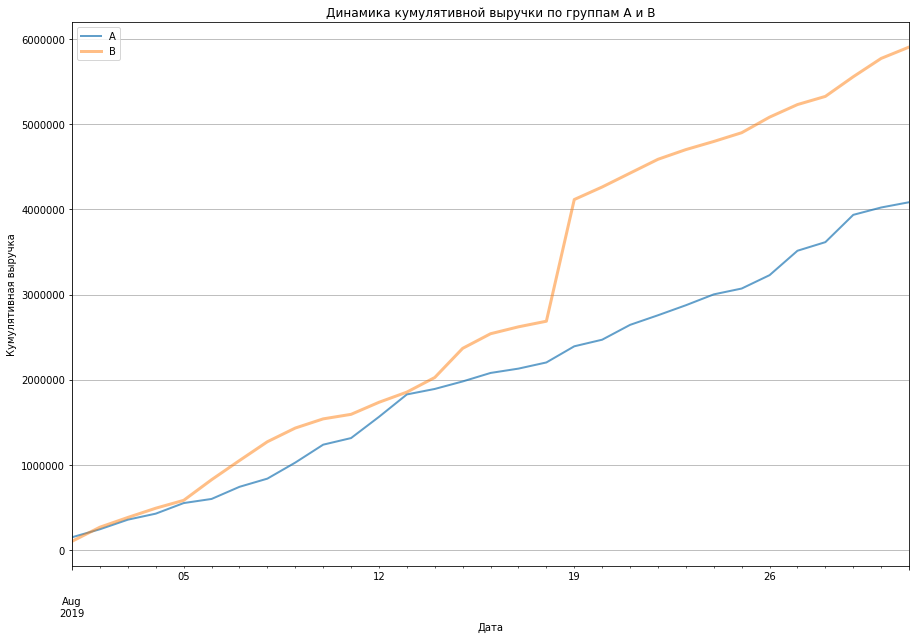

In [22]:
# Строим график выручки групп
print_plot(cumulativeRevenueA, cumulativeRevenueB, x="date", y="revenue", 
           title="Динамика кумулятивной выручки по группам А и В", 
           xl="Дата", 
           yl="Кумулятивная выручка" )

Выручка по группе А почти равномерно увеличивается в течение всего теста, что хорошо. Выручка в группе В резко возрастает к 19 августа и продолжает лидировать. Скорее всего, повлияли аномально дорогие заказы в выборке. 

Посмотрим график кумулятивного среднего чека по группам.

In [23]:
# средний чек в таблицах
cumulativeRevenueA['avg_cheak'] = cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'] 
cumulativeRevenueB['avg_cheak'] = cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'] 

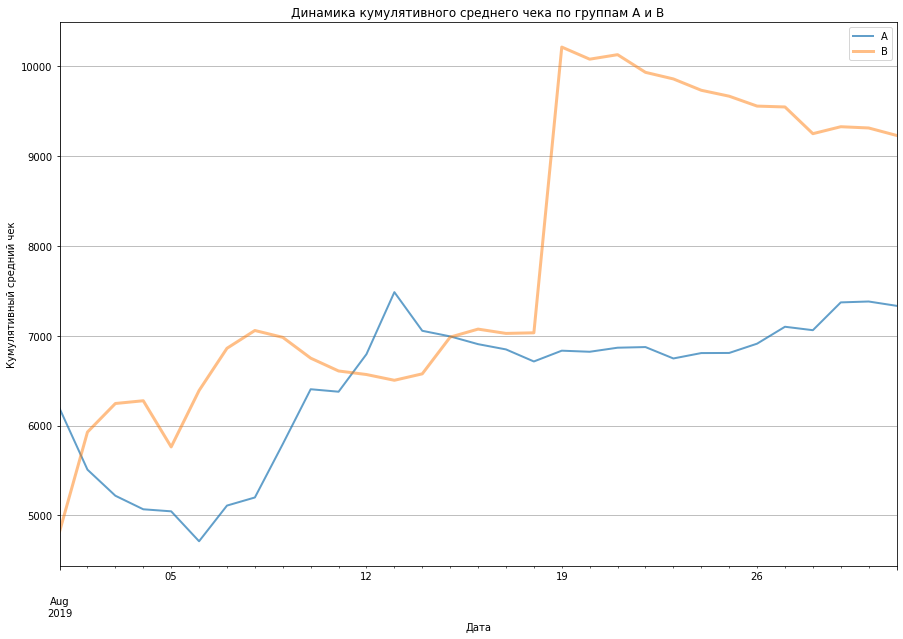

In [24]:
# Строим график кумулятивного среднего чека 
# разделим кумулятивную выручку на кумулятивное число заказов

print_plot(cumulativeRevenueA, cumulativeRevenueB, x="date", y="avg_cheak", 
           title="Динамика кумулятивного среднего чека по группам А и В", 
           xl="Дата", 
           yl="Кумулятивный средний чек" )


Средний чек по группе А возрастает к середине месяца и становится равномерным ближе к концу теста. По группе В средний чек был примерно одинаков с 10 по 18 августа и резко возрастает 19 августа. Возможно, в группу B попал крупный заказ (резкий скачок на графике). Нужно избавиться от аномально крупных заказов и сравнить результат без них. Также интересна большая протяженность тестирования, чтобы прийти к реальному установившемуся среднему чеку.

Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

In [25]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeRevenue.head(5)

,date,revenueA,ordersA,avg_cheakA,revenueB,ordersB,avg_cheakB
0,2019-08-01,148579,24,6190.791667,101217,21,4819.857143
1,2019-08-02,242401,44,5509.113636,266748,45,5927.733333
2,2019-08-03,354874,68,5218.735294,380996,61,6245.836066
3,2019-08-04,425699,84,5067.845238,489567,78,6276.500000
4,2019-08-05,549917,109,5045.110092,581995,101,5762.326733


In [26]:
#Функция для графиков
#Напишем функцию, строящую графики типа plot для одного датасета 
    
def print_plot_one(a, b, x="", y="", title="", xl="", yl=""):    
    plt.figure(figsize=(15, 10)) #задали размер графика
    plt.plot(x, y)
    plt.xlabel(xl) #подписали ось х
    plt.ylabel(yl) #подписали ось y
    ax = plt.axes() 
    ax.set_title(title) #подписали график
    ax.set_ylim([a, b])
    plt.axhline(y=0, color='black', linestyle='--') # Добавим горизонтальную ось методом axhline() 
    plt.show()  
    

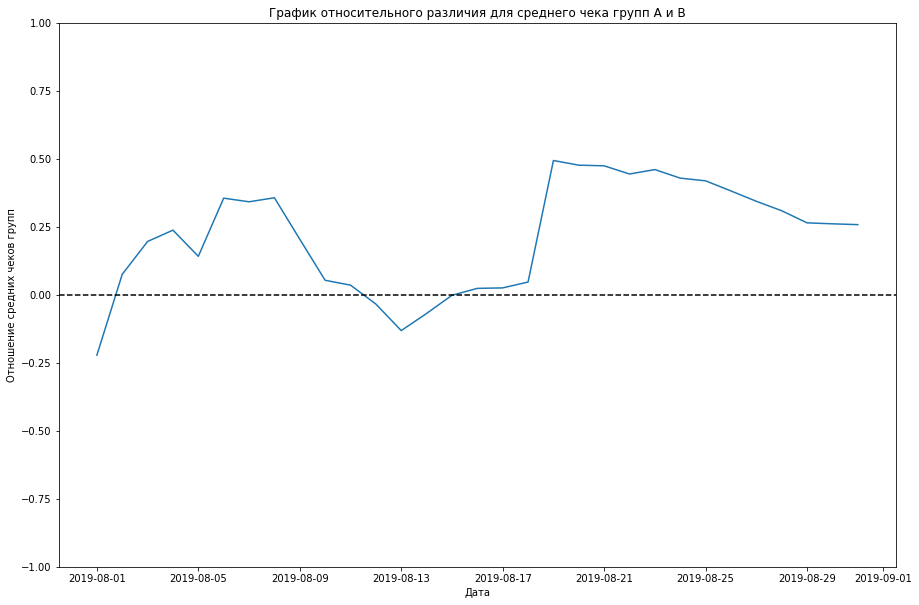

In [27]:
# cтроим график относительного различия средних чеков
print_plot_one(-1, 1, mergedCumulativeRevenue['date'], mergedCumulativeRevenue['avg_cheakB']/mergedCumulativeRevenue['avg_cheakA']-1,
               title="График относительного различия для среднего чека групп А и В",
               xl="Дата",
               yl="Отношение средних чеков групп")

В нескольких точках график различия между группами резко повышается и снижается. Значит, где-то были крупные крупные заказы/ выбросы, что повлияло на динамику.

Построим график кумулятивной конверсии по группам.

In [28]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
cumulativeData

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
1,2019-08-01,B,21,20,101217,713,0.029453
2,2019-08-02,A,44,38,242401,1338,0.032885
3,2019-08-02,B,45,43,266748,1294,0.034776
4,2019-08-03,A,68,62,354874,1845,0.036856
...,...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708,0.033657
58,2019-08-30,A,545,493,4022970,18037,0.030216
59,2019-08-30,B,620,567,5774631,18198,0.034070
60,2019-08-31,A,557,503,4084803,18736,0.029729


In [29]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

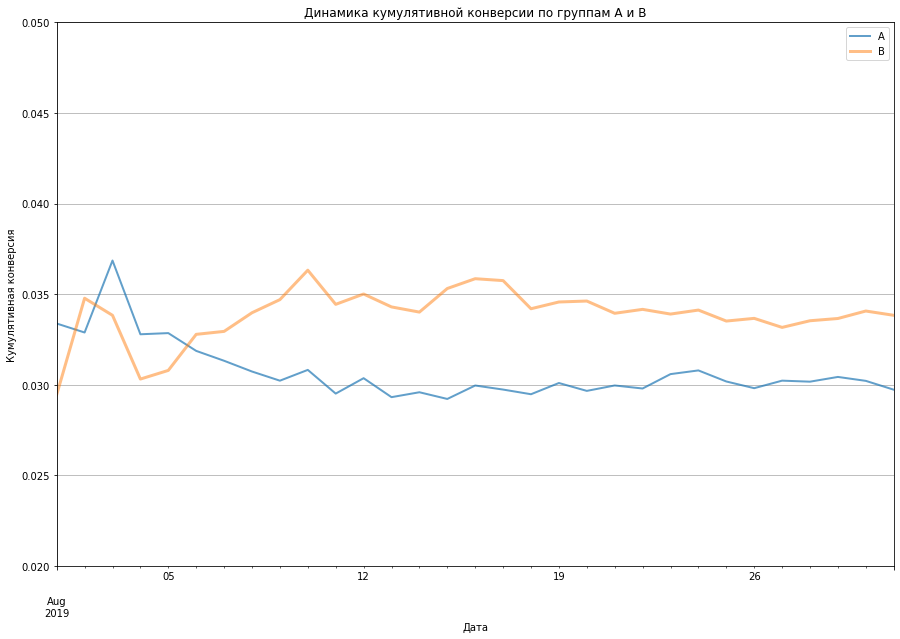

In [30]:
# Строим график кумулятивной конверсии по группам

print_plot_limit(0.02, 0.05, cumulativeDataA, cumulativeDataB, x="date", y="conversion", 
           title="Динамика кумулятивной конверсии по группам А и В", 
           xl="Дата", 
           yl="Кумулятивная конверсия")
 

Получился достаточно симметричный график относительно значения 0,032. Группы колебались около одного значения, но затем конверсия группы В выросла и зафиксировалась около значения 0,034, а конверсия группы B снизилась и также зафиксировалась около 0,030. Абсолютное значение колебания конверсии в конце теста примерно 4%.
Построим график относительного изменения кумулятивной конверсии группы B к группе A.


In [31]:
# Объединим таблицы 
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', 
                                                                           right_on='date', 
                                                                           how='left', 
                                                                           suffixes=['A', 'B'])

In [32]:
mergedCumulativeConversions.head(5)

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


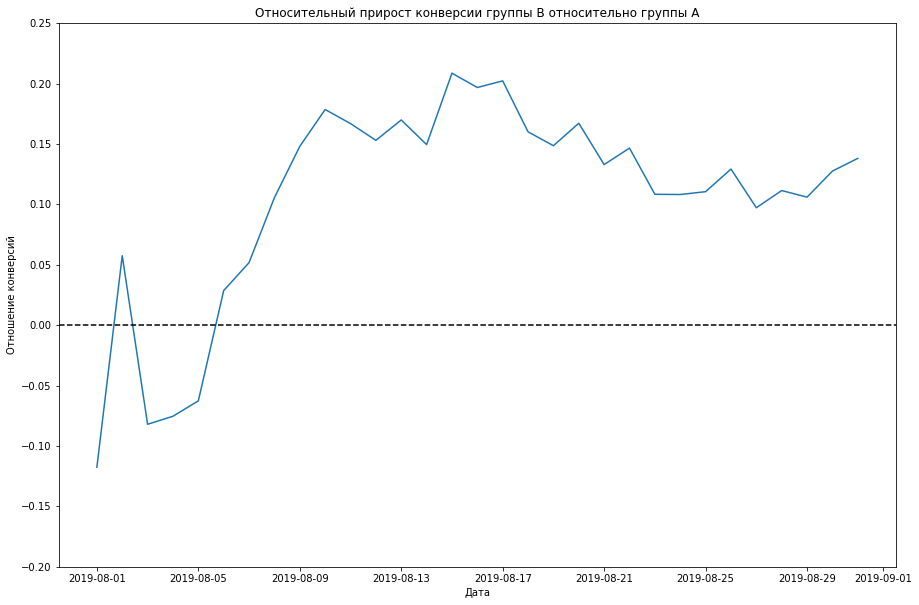

In [33]:
# cтроим график относительного изменения кумулятивной конверсии группы B к группе A
print_plot_one(-0.2, 0.25, mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
               title="Относительный прирост конверсии группы B относительно группы A",
               xl="Дата",
               yl="Отношение конверсий")

В начале теста значения конверсии групп А и В колебались возле 0, затем группа В вышла вперёд. Сейчас ее прирост зафиксировался возле значения 13% относительно группы А.

Стоит проанализировать аномалии, возможно, они изменят график. 

Для этого изучим данные о заказах. Посмотрим точечный график количества заказов по пользователям.

In [34]:
# подсчитаем количество заказов по пользователям 
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['userId', 'orders']
ordersByUsers.head(5)

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,2
3,11685486,1
4,39475350,1


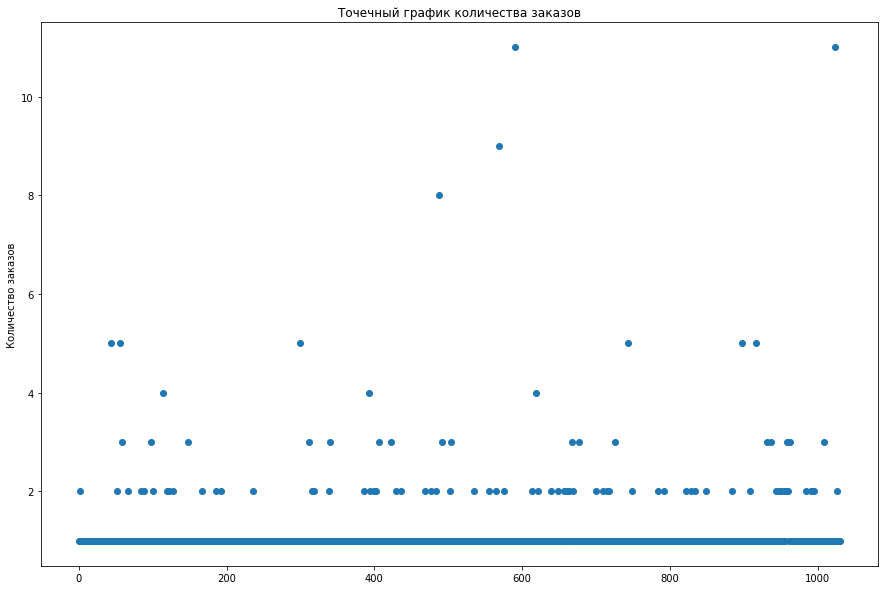

In [35]:
# граффик типа scatter количества заказов по пользователям
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(15, 10)) #задали размер графика
plt.scatter(x_values, ordersByUsers['orders']) 
plt.ylabel('Количество заказов') #подписали ось y
ax = plt.axes() 
ax.set_title('Точечный график количества заказов') #подписали график
plt.show()  

Большинство покупателей купили товар только один раз. Однако много пользователей купило 2-4 заказа и есть аномальные данные - более 10 заказов.
Посчитаем выборочные перцентили количества заказов на одного пользователя

In [36]:
# Посчитаем 95-й и 99-й перцентили количества заказов 
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Не более 5% пользователей заказывали по 2 раза. Выберем данное количество заказов как границу, по ней отсеим остальных пользователей.

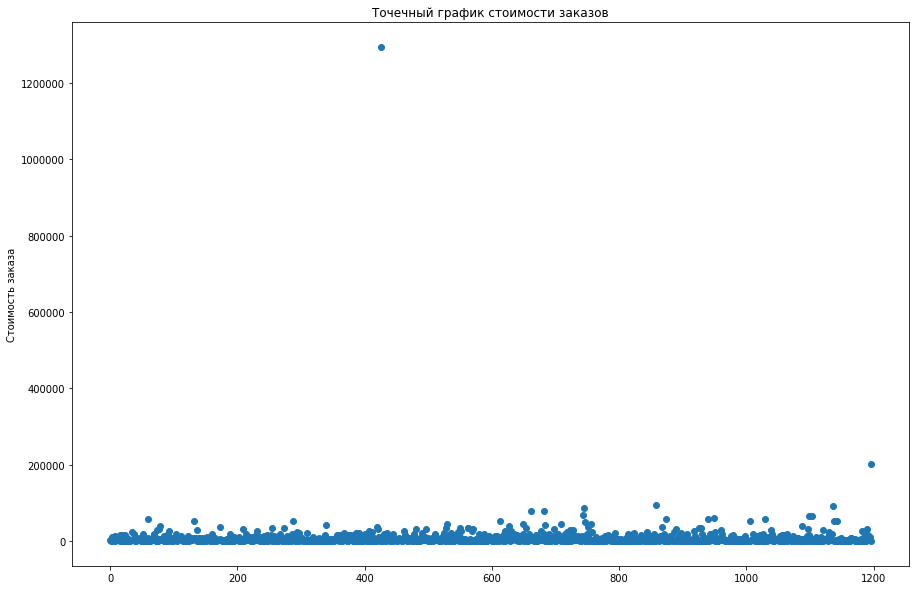

In [37]:
# граффик типа scatter по стоимости заказов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15, 10)) #задали размер графика
plt.scatter(x_values, orders['revenue']) 
plt.ylabel('Cтоимость заказа') #подписали ось y
ax = plt.axes() 
ax.set_title('Точечный график стоимости заказов') #подписали график
plt.show()  

Видно, что есть пара заказов значительно дороже остальных, они как раз искажают результаты сравнения. 
Отсеим наблюдения с максимальными значениями, диапазон примем подсчитав 95 и 99 перцентиль.

In [38]:
# Посчитаем 95-й и 99-й перцентили стоимости заказов 
print(np.percentile(orders['revenue'], [95, 99])) 

[28000.  58233.2]


Границу для определения аномальных заказов примем 95 перцентиль - 28000. Не более 5% заказов дороже 28000. 

Чтобы рассмотреть данные о стоимостях заказов подробнее, применим ограниченние 95 перцентиль на выручку за заказ:

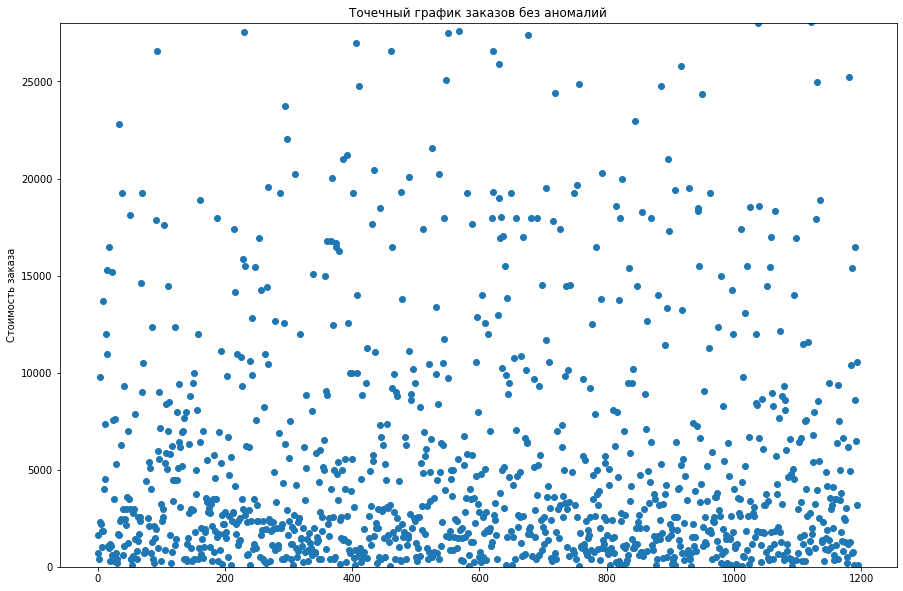

In [39]:
# граффик типа scatter по стоимости заказов без аномалий
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15, 10)) #задали размер графика
plt.scatter(x_values, orders['revenue']) 
plt.ylabel('Cтоимость заказа') #подписали ось y
ax = plt.axes() 
ax.set_ylim(ymin=0, ymax=np.percentile(orders['revenue'], 95))
ax.set_title('Точечный график заказов без аномалий') #подписали график
plt.show()  

Судя по графику, чаще всего делают недорогие покупки, до 5 тыс.руб.

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным - без удаления аномальных пользователей.

In [40]:
# Создадим таблицы посетителей по группе А
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
display('Количество пользователей в выбранную дату в группе A', visitorsADaily.head())
print()
# Создадим таблицы посетителей по группе В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
display('Количество пользователей в выбранную дату в группе B', visitorsBDaily.head())

'Количество пользователей в выбранную дату в группе A'

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


'Количество пользователей в выбранную дату в группе B'

,date,visitorsPerDateB
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [41]:
# Создадим таблицы c количеством
# пользователей до выбранной даты включительно в группе A
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

display('количество пользователей до выбранной даты включительно в группе A', visitorsACummulative.head())
print()

# Создадим таблицы c количеством
# пользователей до выбранной даты включительно в группе В
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

display('количество пользователей до выбранной даты включительно в группе В', visitorsBCummulative.head())


'количество пользователей до выбранной даты включительно в группе A'

,date,visitorsCummulativeA
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


'количество пользователей до выбранной даты включительно в группе В'

,date,visitorsCummulativeB
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [42]:
# количество заказов в выбранную дату в группе A
# суммарная выручка в выбранную дату в группе 
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']
display('количество заказов и суммарная выручка в выбранную дату в группе А', ordersADaily.head())
print()

# количество заказов в выбранную дату в группе B
# суммарная выручка в выбранную дату в группе 
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
display('количество заказов и суммарная выручка в выбранную дату в группе B', ordersBDaily.head())

'количество заказов и суммарная выручка в выбранную дату в группе А'

,date,ordersPerDateA,revenuePerDateA
0,2019-08-01,24,148579
1,2019-08-02,20,93822
2,2019-08-03,24,112473
3,2019-08-04,16,70825
4,2019-08-05,25,124218


'количество заказов и суммарная выручка в выбранную дату в группе B'

,date,ordersPerDateB,revenuePerDateB
0,2019-08-01,21,101217
1,2019-08-02,24,165531
2,2019-08-03,16,114248
3,2019-08-04,17,108571
4,2019-08-05,23,92428


In [43]:
# суммарное число заказов до выбранной даты включительно в группе A
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]
display('суммарное число заказов до выбранной даты включительно в группе A', ordersACummulative.head())
print()
# суммарное число заказов до выбранной даты включительно в группе B
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]
display('суммарное число заказов до выбранной даты включительно в группе B', ordersBCummulative.head())


'суммарное число заказов до выбранной даты включительно в группе A'

,date,ordersCummulativeA,revenueCummulativeA
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


'суммарное число заказов до выбранной даты включительно в группе B'

,date,ordersCummulativeB,revenueCummulativeB
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995


In [44]:
# объединим таблицы 
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)
data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным.

In [45]:
# для пользователей, которые заказывали хотя бы 1 раз, 
# укажем число совершённых заказов 

# группа А
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']
display('Число заказов по пользователям в группе А', ordersByUsersA.head())
print()

# группа В
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders'] 
display('Число заказов по пользователям в группе B', ordersByUsersB.head())

'Число заказов по пользователям в группе А'

,userId,orders
0,8300375,1
1,11685486,1
2,54447517,1
3,66685450,1
4,78758296,1


'Число заказов по пользователям в группе B'

,userId,orders
0,5114589,1
1,6958315,1
2,8300375,1
3,39475350,1
4,47206413,1


In [46]:
# количество не заказавших пользователей в А
indexA = np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders']))
# количество не заказавших пользователей в В
indexB = np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders']))

# Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
# Тем, кто ничего не заказал, будут соответствовать нули. 
sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, indexA, name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, indexB, name='orders')],axis=0)

Число элементов sample — это количество пользователей, сумма всех элементов — количество заказов.

Посчитаем статистическую значимость различия конверсии по результатам А/В-теста, применяя тест Манна-Уитни. 

P-value, как критический уровень статистической значимости примем за 5%, что означает, что мы допускаем 5% вероятность ошибки в полученном результате.
При значениях p-value менее 0,05 следует признать, что можем отвергнуть нулевую гипотезу.

**Нулевая гипотеза: По "сырым" данным конверсия группы А равна конверсии группы В.**

**Альтернативная гипотеза: По "сырым" данным конверсия группы А отличается от конверсии группы В.**

In [47]:
# Выведем p-value для сравнения конверсии между группами. 
print('p-value при сравнения конверсии между группами по "сырым" данным:')
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

p-value при сравнения конверсии между группами по "сырым" данным:
0.008


P-value < 0.05, что значит, что мы можем отвергнуть нулевую гипотезу о равенстве конверсий выборок, и есть основания полагать, что конверсии групп отличаются.

In [48]:
# Выведем относительное различие в конверсии между группами.
# конверсия группы B / конверсия группы A - 1
print('Относительное различие в конверсии между группами по "сырым" данным:')
print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Относительное различие в конверсии между группами по "сырым" данным:
0.138


Конверсия группы B выше конверсии группы A на 13,8%.
Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

**Нулевая гипотеза: По "сырым" данным средний чек группы А равен среднему чеку группы В.**

**Альтернативная гипотеза: По "сырым" данным средний чек группы А отличается от среднего чека группы В.**

In [49]:
# Выведем p-value для сравнения средних чеков между группами. 
print('p-value при сравнения среднего чека между группами по "сырым" данным:')
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))

p-value при сравнения среднего чека между группами по "сырым" данным:
0.365


P-value > 0.05, что значит, что мы не можем отвергнуть нулевую гипотезу о равенстве средних чеков по группам.

In [50]:
# Выведем относительное различие в средних чеках между группами.  
# средний чек группы B / средний чек группы A - 1
print('Относительное различие в средних чеках между группами по "сырым" данным:')
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

Относительное различие в средних чеках между группами по "сырым" данным:
0.259


Средний чек группы B значительно выше среднего чека группы A. Вероятно, это произошло из-за выбросов. Очистим данные и проанализируем еще раз.

Примем за аномальных пользователей тех, кто в упорядоченной выборке выше 95 перцентиля по количеству заказов и их стоимости. 

In [51]:
# Аномальные пользователи
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 95)]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 95)]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [52]:
# Количество аномальных покупателей
print('Количество аномальных пользователей:', abnormalUsers.shape[0])
# Всего покупателей
print('Всего покупателей:',orders['visitorId'].nunique())
print('Процентное отношение аномальных пользователей: {0:.1%}'.format(abnormalUsers.shape[0]/orders['visitorId'].nunique())) 

Количество аномальных пользователей: 74
Всего покупателей: 1031
Процентное отношение аномальных пользователей: 7.2%


Всего аномальных покупателей 74, что составляет примерно 7% выборки. 

Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [53]:
# Выборка количества заказов по пользователям по группе А
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0, indexA ,name='orders'
        ),
    ],
    axis=0,
)

# Выборка количества заказов по пользователям по группе В
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0, indexB ,name='orders'
        ),
    ],
    axis=0,
)


Применим статистический критерий Манна-Уитни к полученным выборкам.
При значениях p-value менее 0,05 следует признать, что можем отвергнуть нулевую гипотезу. 

**Нулевая гипотеза: По "очищенным" данным конверсия группы А равна конверсии группы В.**

**Альтернативная гипотеза: По "очищенным" данным конверсия группы А отличается от конверсии группы В.**


In [54]:
# Выведем p-value для сравнения конверсии между группами. 
print('p-value при сравнения конверсии между группами по "очищенным" данным:')
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

p-value при сравнения конверсии между группами по "очищенным" данным:
0.007


P-value был 0.008, стал 0.007, это < 0.05, что значит, что мы можем отвергнуть нулевую гипотезу о равенстве конверсий выборок, и есть основания полагать, что конверсии групп отличаются. Это не изменилось по группе фильтрованных данных.

In [55]:
# Выведем относительное различие в конверсии между группами.  
# конверсия группы B / конверсия группы A - 1
print('Относительное различие в конверсии между группами по "очищенным" данным:')
print("{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

Относительное различие в конверсии между группами по "очищенным" данным:
0.173


Относительное различие в конверсии показывает преимущество конверсии группы B над конверсией группы A на 13,8% по нефильтрованным данным и на 17,3% по фильтрованным данным.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по фильтрованным данным.

**Нулевая гипотеза: По "очищенным" данным средний чек группы А равен среднему чеку группы В.**

**Альтернативная гипотеза: По "очищенным" данным средний чек группы А отличается от среднего чека группы В.**

In [56]:
ordersA_filt = orders[np.logical_and(orders['group'] == 'A',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']
ordersB_filt = orders[np.logical_and(orders['group'] == 'B',np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue']

# Результаты по среднему чеку
print('p-value при сравнения среднего чека между группами по "очищенным" данным:')
print('{0:.3f}'.format(stats.mannwhitneyu(ordersA_filt,ordersB_filt)[1]))

p-value при сравнения среднего чека между группами по "очищенным" данным:
0.369


P-value не изменился, что значит, что мы по-прежнему не можем отвергнуть нулевую гипотезу о равенстве средних чеков по группам, нет статистической значимости различия средних чеков заказов групп А и В

In [57]:
# Выведем относительное различие в средних чеках между группами.  
# средний чек группы B / средний чек группы A - 1 по фильтрованным данным
print('Относительное различие в среднем чеке между группами по "очищенным" данным:')
print("{0:.3f}".format(ordersB_filt.mean()/ordersA_filt.mean()- 1)) 

Относительное различие в среднем чеке между группами по "очищенным" данным:
-0.020


Данные поменялись. Средний чек группы В теперь немного ниже среднего чека группы A, так повлияло удаление выбросов.

### Выводы по результатам A/B-теста


•	Есть статистически значимые различия по конверсии между группами и по «сырым», и по данным после фильтрации аномалий. 
Относительное различие в конверсии показывает преимущество конверсии группы B над конверсией группы A на 13,8% по нефильтрованным данным и на 17,3% по фильтрованным данным.

•	Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий.
Относительное различие по среднему чеку показывает по «сырым» данным преимущество по группе В на 25%, но по фильтрованным данным относительное различие по среднему чеку практически одинаково, в группе В ниже на 2%.

•	График различия конверсии между группами показывает, что результаты группы B лучше результатов группы A и разница в конверсии зафиксировалась.

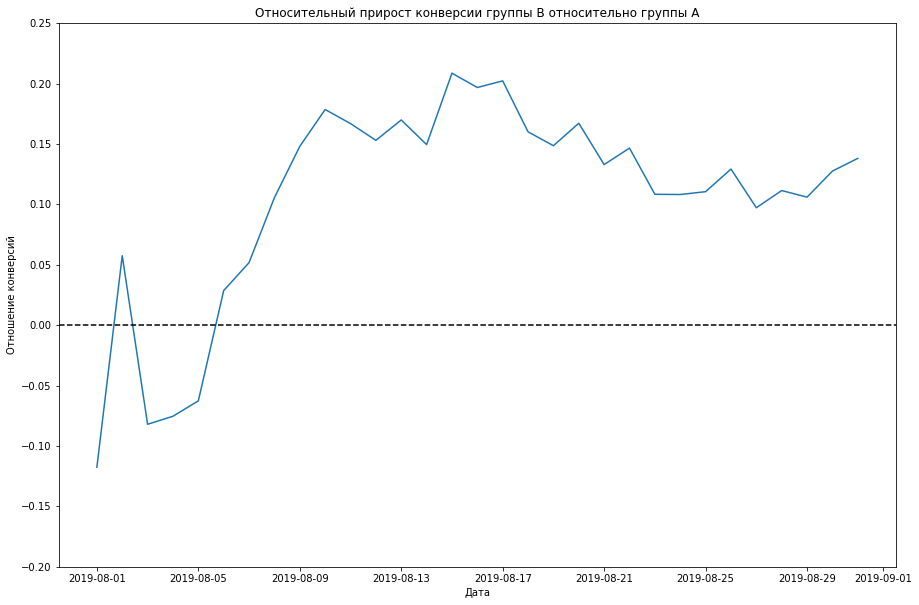

In [58]:
# cтроим график относительного изменения кумулятивной конверсии группы B к группе A
print_plot_one(-0.2, 0.25, mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1,
               title="Относительный прирост конверсии группы B относительно группы A",
               xl="Дата",
               yl="Отношение конверсий")

•	График различия среднего чека колеблется, что выдает аномалии в стоимостях заказов.

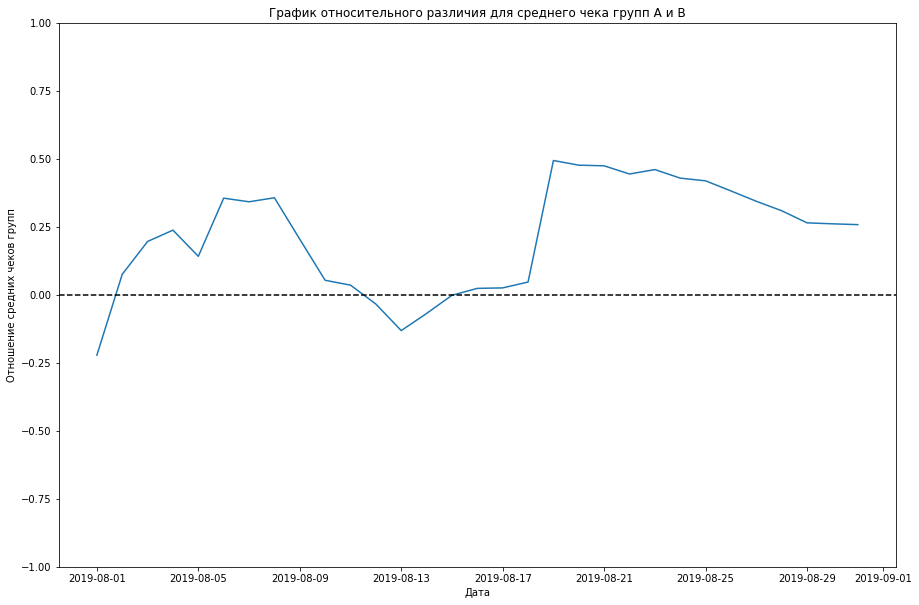

In [59]:
# cтроим график относительного различия средних чеков
print_plot_one(-1, 1, mergedCumulativeRevenue['date'], mergedCumulativeRevenue['avg_cheakB']/mergedCumulativeRevenue['avg_cheakA']-1,
               title="График относительного различия для среднего чека групп А и В",
               xl="Дата",
               yl="Отношение средних чеков групп")

Итог:

По результатам рекомендовано остановить тест, признать его успешным, зафиксировать преимущество по конверсии группы В.

По среднему чеку признать преимущество одной группы над другой нельзя.

## Вывод

Данные для анализа предоставлены без дубликатов и нулевых значений. В ходе работы были приоритизированы предоставленные гипотезы по методике ICE и RICE.

Рекомендовано, в первую очередь, протестировать гипотезу 7. Далее по приоритету следует гипотеза 2, за ней - гипотеза 6.
Малоэффективными следует признать гипотезы 1, 5, 3, 4.

Проведен анализ А/В-тестирования. По результатам рекомендовано остановить тест, признать его успешным, зафиксировать преимущество по конверсии группы B над конверсией группы A на 13,8% по нефильтрованным данным и на 17,3% по фильтрованным данным.

По среднему чеку признать преимущество одной группы над другой нельзя.